<a href="https://colab.research.google.com/github/et-tran50/CASE/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [49]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import shap
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.metrics import precision_recall_fscore_support
from imblearn.over_sampling import SMOTE

# Data Loading and Processing

In [50]:
train_data = pd.read_csv('/content/Training Dataset A_R-384922_Candidate Attach #1_PresSE_SRF #1141.csv')
eval_data = pd.read_csv('/content/Evaluation Dataset B_R-384922_Candidate Attach #2_PresSE_SRF #1141.csv')

In [51]:
# Separate features and target variable
y = train_data['aprv_flag']  # Keep target separately
X = train_data.drop(columns=['aprv_flag'])  # Drop target column
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, stratify=y, random_state=42)


# Data Summary

In [53]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21606 entries, 0 to 21605
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   fico                              21431 non-null  float64
 1   amtfinanced_1req                  21606 non-null  float64
 2   collateral_dlrinput_newused_1req  21606 non-null  object 
 3   pti_1req                          21603 non-null  float64
 4   ltv_1req                          21601 non-null  float64
 5   p12_reh7120_a                     19694 non-null  float64
 6   p12_bcx7110_a                     17917 non-null  float64
 7   p12_all7170_a                     20943 non-null  float64
 8   p12_aut7110_a                     11070 non-null  float64
 9   p12_all7120_a                     21226 non-null  float64
 10  p12_all7937_a                     21522 non-null  float64
 11  p12_bcc8120_a                     19752 non-null  float64
 12  p12_

In [54]:
# Mean, median, standard deviation, min, max.
print(X.describe())

               fico  amtfinanced_1req      pti_1req      ltv_1req  \
count  21431.000000      21606.000000  21603.000000  21601.000000   
mean     703.643087      29870.867118      9.025000    101.188938   
std       82.786470      15311.300550      4.803567     23.245966   
min      372.000000          0.000000      0.080000     10.350000   
25%      644.000000      19370.000000      5.930000     90.520000   
50%      701.000000      26806.000000      8.590000    103.470000   
75%      766.000000      36931.250000     11.580000    113.800000   
max      894.000000     189729.000000    207.090000    955.260000   

       p12_reh7120_a  p12_bcx7110_a  p12_all7170_a  p12_aut7110_a  \
count   19694.000000   17917.000000   20943.000000   11070.000000   
mean       51.866406      35.863370       3.597288      66.256459   
std        37.352331      33.225946      14.888786      24.470168   
min         0.000000       0.000000       0.000000       0.000000   
25%        16.000000       6.0000

In [55]:
# Percentage of missing data for each column.
print(X.isnull().sum() / len(X) * 100)

fico                                 0.809960
amtfinanced_1req                     0.000000
collateral_dlrinput_newused_1req     0.000000
pti_1req                             0.013885
ltv_1req                             0.023142
p12_reh7120_a                        8.849394
p12_bcx7110_a                       17.073961
p12_all7170_a                        3.068592
p12_aut7110_a                       48.764232
p12_all7120_a                        1.758771
p12_all7937_a                        0.388781
p12_bcc8120_a                        8.580950
p12_iln7410_a                       10.376747
p12_rev1300_a                        3.684162
p12_all8150_a                       57.386837
p12_bca8370_a                        7.335925
p12_all7517_a                        1.592150
p12_iln8220_a                        8.932704
p12_all6250_a                        0.000000
p12_aua8151_a                       82.449320
p12_rtr7110_a                       42.927890
p12_pil8120_a                     

# XGBoost

We employ XGboost to learn our dataset, cross validating to get the best parameters to train our models with.

In [56]:
param_grid = {
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [len(y_train[y_train == 0]) / len(y_train[y_train == 1])]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=100, random_state=42),
                           param_grid=param_grid, scoring='precision', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


# Accuracy Report

In [57]:
validation_accuracy = accuracy_score(y_test, y_pred_best)
roc_auc = roc_auc_score(y_test, y_pred_best)
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Validation AUROC: {roc_auc:.4f}")

Validation Accuracy: 0.8269
Validation AUROC: 0.8114


In [58]:
print("Classification Report for Tuned Model:")
print(classification_report(y_test, y_pred_best))

Classification Report for Tuned Model:
              precision    recall  f1-score   support

           0       0.64      0.78      0.70      1696
           1       0.92      0.84      0.88      4786

    accuracy                           0.83      6482
   macro avg       0.78      0.81      0.79      6482
weighted avg       0.84      0.83      0.83      6482



Intersection Threshold: 0.4082
Precision: 0.8993, Recall: 0.8993


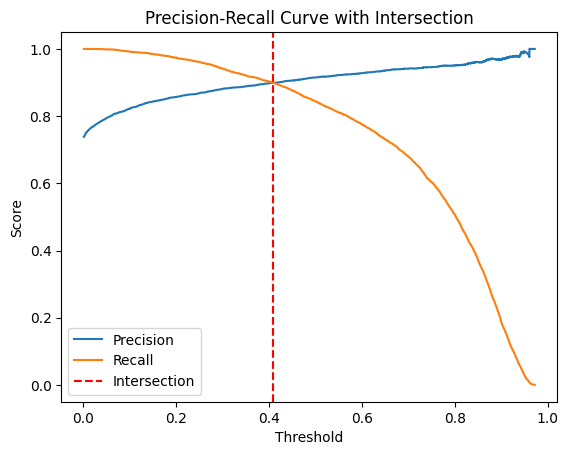

In [59]:
# Get predicted probabilities for the positive class
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_best)

# Find the intersection point where precision equals recall
differences = np.abs(precisions[:-1] - recalls[:-1])  # Exclude the last threshold
intersection_index = np.argmin(differences)  # Index of the closest point
intersection_threshold = thresholds[intersection_index]
print(f"Intersection Threshold: {intersection_threshold:.4f}")
print(f"Precision: {precisions[intersection_index]:.4f}, Recall: {recalls[intersection_index]:.4f}")

# Plot the Precision-Recall Curve
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.axvline(x=intersection_threshold, color="red", linestyle="--", label="Intersection")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall Curve with Intersection")
plt.show()

In [60]:
# Get predicted probabilities
y_probs = best_model.predict_proba(X_test)[:, 1]

# Set a custom threshold
y_pred_custom = (y_probs >= intersection_threshold).astype(int)

precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
f1 = f1_score(y_test, y_pred_custom)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Evaluate performance
print(f"Classification Report with Best Threshold {intersection_threshold}:")
print(classification_report(y_test, y_pred_custom))

Precision: 0.90
Recall: 0.90
F1-Score: 0.90
Classification Report with Best Threshold 0.4082378149032593:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1696
           1       0.90      0.90      0.90      4786

    accuracy                           0.85      6482
   macro avg       0.81      0.81      0.81      6482
weighted avg       0.85      0.85      0.85      6482



# Evaluation

In [61]:
from sklearn.metrics import accuracy_score

# Apply the same preprocessing steps to Dataset B
X_eval = eval_data.drop(columns=['aprv_flag'])  # Separate features and target
y_eval = eval_data['aprv_flag']
X_eval_encoded = pd.get_dummies(X_eval, columns=categorical_cols, drop_first=False)
X_eval_encoded = X_eval_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# Predict probabilities on the evaluation dataset
y_eval_proba = best_model.predict_proba(X_eval_encoded)[:, 1]

# Apply custom threshold
y_eval_pred_custom = (y_eval_proba >= intersection_threshold).astype(int)

# Calculate evaluation accuracy with the custom threshold
evaluation_accuracy_custom = accuracy_score(y_eval, y_eval_pred_custom)
print(f"Evaluation Accuracy with Custom Threshold: {evaluation_accuracy_custom:.4f}")

Evaluation Accuracy with Custom Threshold: 0.8439


Evaluation on Minority Class

In [62]:
# Filter for the minority class
minority_indices = (y_eval == 0)
y_eval_minority = y_eval[minority_indices]
y_eval_pred_minority = y_eval_pred_custom[minority_indices]

accuracy_minority = (y_eval_minority == y_eval_pred_minority).mean()
print(f"Accuracy for the Minority Class: {accuracy_minority:.2%}")

Accuracy for the Minority Class: 72.06%


# Question 1

*   Q: Suppose an applicant is rejected by our model, how would we explain why?

*   A: SHAP values decompose the prediction for an individual into contributions from each feature, helping us explain why the model made a specific decision.




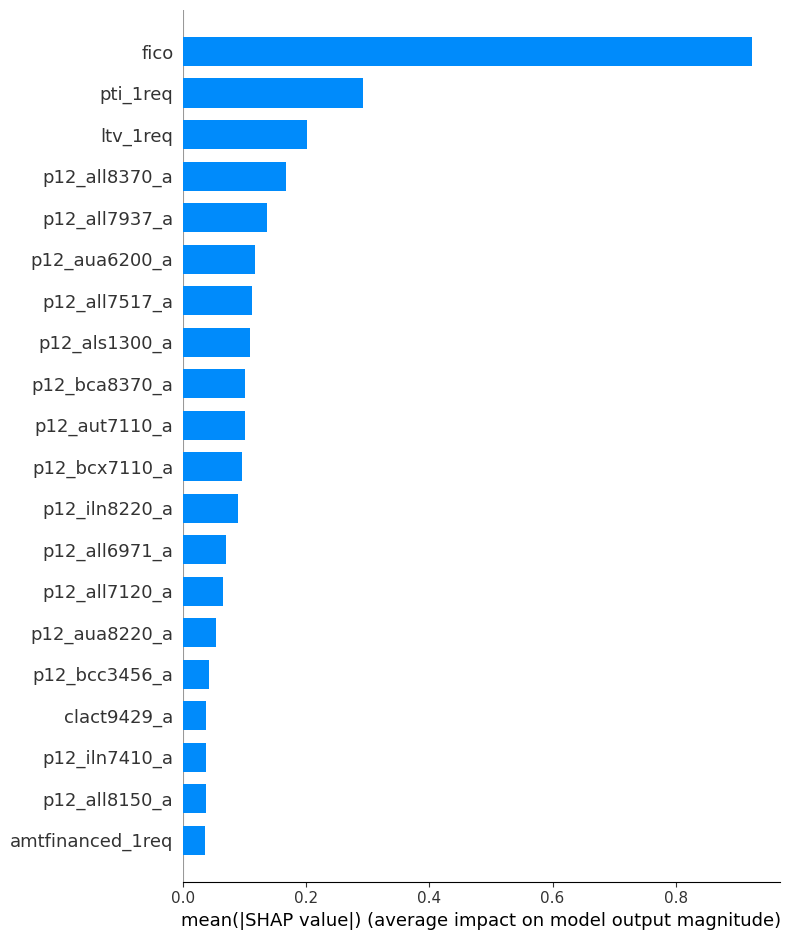

In [63]:
explainer = shap.TreeExplainer(best_model)
# Calculate and plot SHAP values for the test set
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_encoded.columns, plot_type="bar")

# Q2


1.   Q: Do female customers have a lower approval rate in our model?
2.   A: In our model, female customers do have a lower approval rate, though the results are not statistically significant.



In [64]:
female_customers = X_test[X_test['Gender_Female'] == True]
female_labels = y_test[X_test['Gender_Female'] == True]
male_customers = X_test[X_test['Gender_Male'] == True]
male_labels = y_test[X_test['Gender_Male'] == True]

# Overall dataset predictions
overall_predictions = best_model.predict(X_test)

# Female-specific predictions
female_predictions = best_model.predict(female_customers)

# Female-specific predictions
male_predictions = best_model.predict(male_customers)

In [65]:
# Overall approval rate. We can sum since the entries are either 0 or 1
overall_approval_rate = sum(overall_predictions) / len(overall_predictions)

# approval rates
female_approval_rate = sum(female_predictions) / len(female_predictions)
male_approval_rate = sum(male_predictions) / len(male_predictions)

print(f"Overall Approval Rate: {overall_approval_rate:.2%}")
print(f"Female Approval Rate: {female_approval_rate:.2%}")
print(f"Male Approval Rate: {male_approval_rate:.2%}")


Overall Approval Rate: 68.10%
Female Approval Rate: 68.82%
Male Approval Rate: 67.45%


We choose to perform $Z$-test over chi-squared testing, as it is more geniune to compare female vs male approval rates as our hypothesis, moreso than female vs all, since the original dataset has an undefined entry for gender (could be either).

In [66]:
from statsmodels.stats.proportion import proportions_ztest

# Total approvals for females and males
female_approvals = (female_predictions == 1).sum()
male_approvals = (male_predictions == 1).sum()

# Total observations for females and males
female_total = len(female_predictions)
male_total = len(male_predictions)

# Perform the two-proportion Z-test
count = [female_approvals, male_approvals]
nobs = [female_total, male_total]
stat, p_value = proportions_ztest(count, nobs)

# Output results
print(f"Z-Statistic: {stat:.4f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("The difference in approval rates is statistically significant.")
else:
    print("The difference in approval rates is not statistically significant.")


Z-Statistic: 1.1392, p-value: 0.2546
The difference in approval rates is not statistically significant.
